## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
#from sentence-transformers import SentenceTransformer, util

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import networkx as nx


In [ ]:
%%capture
!pip install community
!pip install python-louvain
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Explore and prepare graph

In [ ]:
df = pd.read_csv('IMDB_movie_details.csv')
df.head()

movie_id                                       plot_summary  duration  \
0  tt0105112  Former CIA analyst, Jack Ryan is in England wi...  1h 57min   
1  tt1204975  Billy (Michael Douglas), Paddy (Robert De Niro...  1h 45min   
2  tt0243655  The setting is Camp Firewood, the year 1981. I...  1h 37min   
3  tt0040897  Fred C. Dobbs and Bob Curtin, both down on the...   2h 6min   
4  tt0126886  Tracy Flick is running unopposed for this year...  1h 43min   

                               genre  rating release_date  \
0             ['Action', 'Thriller']     6.9   1992-06-05   
1                         ['Comedy']     6.6   2013-11-01   
2              ['Comedy', 'Romance']     6.7   2002-04-11   
3  ['Adventure', 'Drama', 'Western']     8.3   1948-01-24   
4     ['Comedy', 'Drama', 'Romance']     7.3   1999-05-07   

                                       plot_synopsis  \
0  Jack Ryan (Ford) is on a "working vacation" in...   
1  Four boys around the age of 10 are friends in ...   
2                                                NaN   
3  Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...   
4  Jim McAllister (Matthew Broderick) is a much-a...   

                          title  
0              Giochi di potere  
1                    Last Vegas  
2       Wet Hot American Summer  
3  Il tesoro della Sierra Madre  
4                      Election

In [ ]:
# fill null synopsis with summary
df['plot_synopsis'].fillna(df['plot_summary'], inplace=True)
#check that synopsis is string
df.loc[:, 'plot_synopsis'] = df.loc[:,'plot_synopsis'].astype(str, errors='ignore')

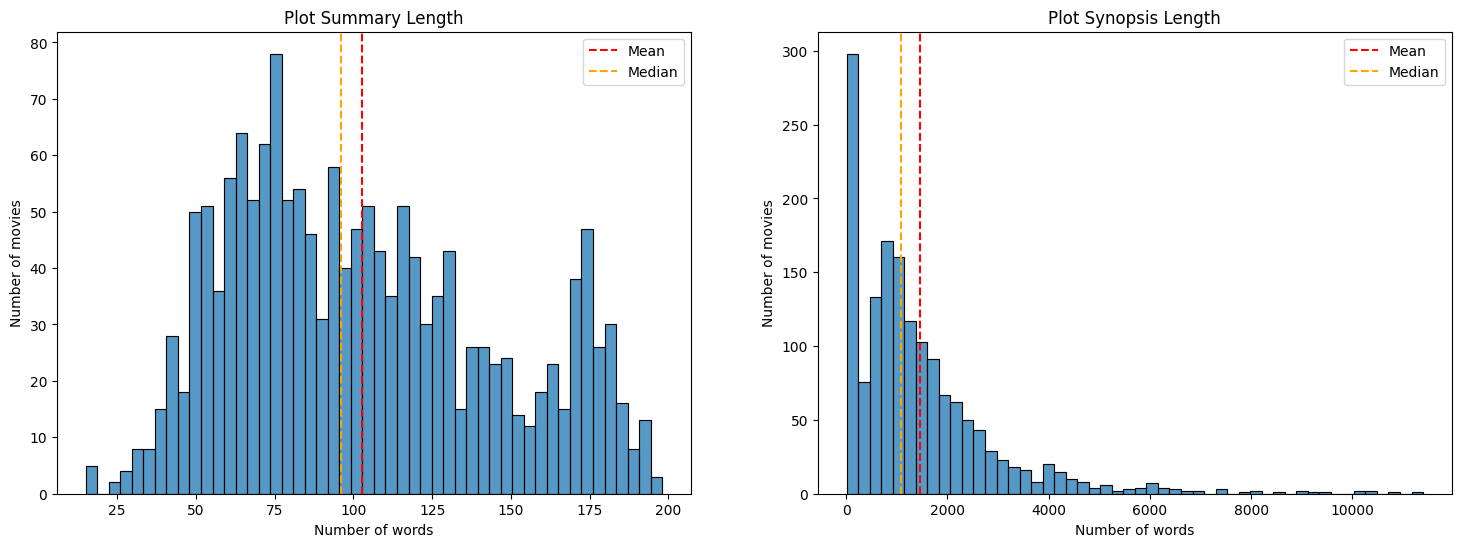

In [ ]:
# plot average length of plot summary and synopsis
df['plot_summary_len'] = df.plot_summary.apply(lambda x: len(x.split()))
df['plot_synopsis_len'] = df.plot_synopsis.apply(lambda x: len(x.split()))

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(df['plot_summary_len'], bins=50, ax=ax[0])
# vertical line on the mean and median
ax[0].axvline(df['plot_summary_len'].mean(), color='red', linestyle='--', label='Mean')
ax[0].axvline(df['plot_summary_len'].median(), color='orange', linestyle='--')
ax[0].set_title('Plot Summary Length')
ax[0].set_xlabel('Number of words')
ax[0].set_ylabel('Number of movies')
ax[0].legend({'Mean':df['plot_summary_len'].mean(),'Median':df['plot_summary_len'].median()})

sns.histplot(df['plot_synopsis_len'], bins=50, ax=ax[1])
ax[1].axvline(df['plot_synopsis_len'].mean(), color='red', linestyle='--')
ax[1].axvline(df['plot_synopsis_len'].median(), color='orange', linestyle='--')
ax[1].set_title('Plot Synopsis Length')
ax[1].set_xlabel('Number of words')
ax[1].set_ylabel('Number of movies')
ax[1].legend({'Mean':df['plot_synopsis_len'].mean(),'Median':df['plot_synopsis_len'].median()})
plt.show()

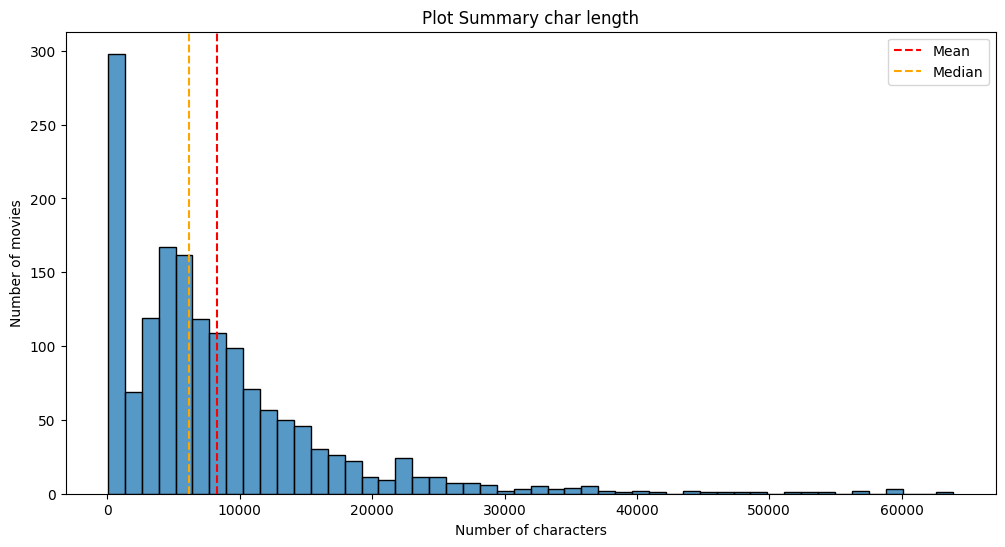

In [ ]:
text_len = pd.DataFrame(columns = ['text_length_words', 'text_length_chars'])

text_len['text_length_chars'] = df['plot_synopsis'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(text_len['text_length_chars'], bins=50)
plt.title('Plot Summary char length')
plt.xlabel('Number of characters')
plt.ylabel('Number of movies')
plt.axvline(text_len['text_length_chars'].mean(), color='red', linestyle='--', label='Mean')
plt.axvline(text_len['text_length_chars'].median(), color='orange', linestyle='--', label='Median')
plt.legend()
plt.show()

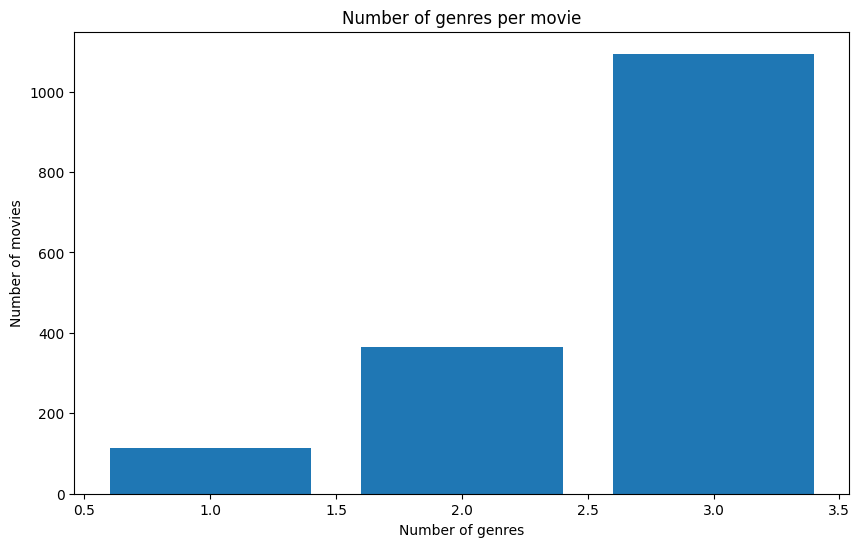

In [ ]:
# get the # genres per movie
df['genre'] = df['genre'].str.split(',')
gen_len =  df['genre'].apply(lambda x: len(x))
gen_lens = dict(gen_len.value_counts())
plt.figure(figsize=(10,6))
plt.bar(gen_lens.keys(), gen_lens.values())
plt.title('Number of genres per movie')
plt.xlabel('Number of genres')
plt.ylabel('Number of movies')
plt.show()

### Text pre-processing

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def preprocessing(corpus): #revise this
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    corpus = re.sub(r'[^\w\s]', '', corpus)
    tokens = word_tokenize(corpus)
    tokens = [word.lower() for word in tokens]
    tokens = [word.replace(',' , '') for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return [''.join(token) for token in tokens]

df['processed'] = df.plot_synopsis.astype(str).apply(lambda x: preprocessing(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df.processed = df.processed.apply(lambda x: ' '.join(x))
df.processed.head()

0    jack ryan ford working vacation london family ...
1    four boy around age 10 friend brooklyn 50 nick...
2    setting camp firewood year 1981 last day every...
3    fred dobbs humphrey bogart bob curtin tim holt...
4    jim mcallister matthew broderick muchadmired h...
Name: processed, dtype: object

In [ ]:
def embed_text():

  if not os.path.exists('./embedding_synopsys.npy'):
    print('Start calculating embeddings...')
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    print(f'... using {model}')
    embeddings = model.encode(df['processed'])

    np.save('embedding_synopsys.npy',embeddings)
  else:
    print('Loading existing embeddings...')
    embeddings = np.load('./embedding_synopsys.npy')

  return embeddings

In [ ]:
embeddings = embed_text()

Loading existing embeddings...


In [ ]:
len(embeddings)

1572

In [ ]:
df['embeddings'] = embeddings.tolist()

## Build the fully connected network according to cosine similarities

In [ ]:

G = nx.Graph()

[G.add_node(index, title = row['title'], genre = row['genre'], plot_summary = row['plot_synopsis']) for index, row in df.iterrows()]

for index, row in df.iterrows():
    for i1, r1 in df[index+1:].iterrows():
        cosim =  util.pytorch_cos_sim(row['embeddings'] , r1['embeddings'])
        if cosim > 0.0:
            G.add_edge(index, i1, weight = float(cosim[0][0]))

#remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))


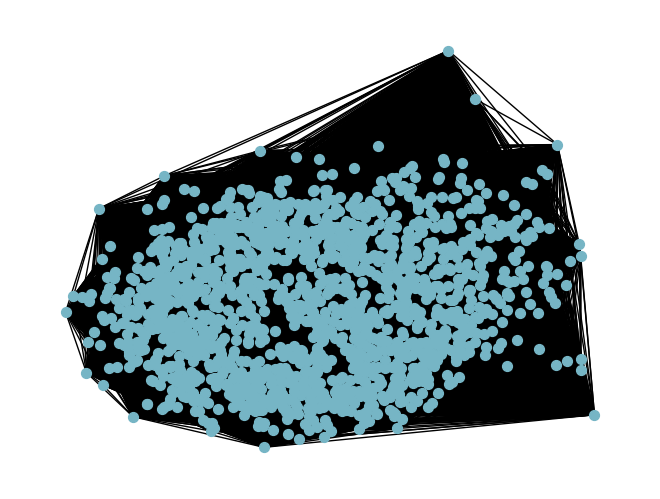

In [ ]:
nx.draw(G, with_labels=False, node_color='#76b5c5', # Custom color specified as a hex code
        node_size=50, font_size=5 , font_weight='normal', edge_color='black')

# Show the plot
plt.show()

In [ ]:
# Calculate mean of each node's strength (sum of connected edge weights)
strengths = {node: sum(weight for _, _, weight in G.edges(node, data='weight')) for node in G.nodes}
# calculate mean and standard deviation of each node's strength
mean_strength = np.mean(list(strengths.values()))
std_strength = np.std(list(strengths.values()))
print(f'Mean strength: {mean_strength}, Standard deviation: {std_strength}')

Mean strength: 450.252796580815, Standard deviation: 91.17440188827395


## Prune back the network applying different algorithms

### Naive method

Use heuristics to set a threshold for reducing network density

In [ ]:
import networkx as nx

G = nx.Graph()

[G.add_node(index, title = row['title'], genre = row['genre'], plot_summary = row['plot_synopsis']) for index, row in df.iterrows()]

for index, row in df.iterrows():
    for i1, r1 in df[index+1:].iterrows():
        cosim =  util.pytorch_cos_sim(row['embeddings'] , r1['embeddings'])
        if cosim > 0.44:  # trial-error threshold chosen for edge creation
            G.add_edge(index, i1, weight = float(cosim[0][0]))

#remove nodes with no edges
G.remove_nodes_from(list(nx.isolates(G)))

### Convex network reduction

In [ ]:
from itertools import combinations

def is_convex_subgraph(subgraph, original_graph):
    """
    Check if the subgraph is convex. A subgraph is convex if the shortest path
    between any two nodes in the subgraph is the same as in the original graph.
    """
    for u, v in combinations(subgraph.nodes, 2):
        if u in original_graph and v in original_graph:
            try:
                if nx.shortest_path_length(subgraph, u, v) != nx.shortest_path_length(original_graph, u, v):
                    return False
            except nx.NetworkXNoPath:
                return False
    return True

def all_induced_subgraphs(graph):
    """
    Generate all induced subgraphs of the graph by all non-empty subsets of nodes.
    """
    for r in range(1, len(graph.nodes()) + 1):
        for nodes in combinations(graph.nodes(), r):
            yield graph.subgraph(nodes)

def check_if_convex_network(graph):
    """
    Check if every induced subgraph is convex.
    """
    for subgraph in all_induced_subgraphs(graph):
        if not is_convex_subgraph(subgraph, graph):
            return False
    return True

# Checking convexity
print("G is convex network:", check_if_convex_network(G))


### Disparity FIltering

In [ ]:
def disparity_filter(G, alpha=0.1):
    """
    Apply the disparity filter to the graph G with a significance level alpha.
    """
    # This will hold the edges we decide to keep
    filtered_graph = nx.Graph()

    # Calculate strength of each node (sum of connected edge weights)
    strengths = {node: sum(weight for _, _, weight in G.edges(node, data='weight')) for node in G.nodes}

    # Iterate over all nodes
    for node in G.nodes:
        # Get neighbors and corresponding edge weights
        neighbors = G.edges(node, data='weight')
        node_strength = strengths[node]

        for node, neighbor, weight in neighbors:
            # Calculate the p-value for each edge
            if node_strength > 0:  # Avoid division by zero
                p_value = 1 - (weight / node_strength)
            else:
                p_value = 1
            # Apply the disparity filter: keep edges where p-value < alpha
            if p_value < alpha:
                # Add both nodes and the weight to the filtered graph
                filtered_graph.add_edge(node, neighbor, weight=weight)

    return filtered_graph


# Applying the disparity filter with a default alpha value of 0.05
filtered_G = disparity_filter(G)

# Print the edges that were kept
print("Edges kept after applying the disparity filter:")
print(filtered_G.edges(data=True))


Edges kept after applying the disparity filter:
[]


In [ ]:
from scipy.stats import norm

def adjusted_disparity_filter(G, alpha=0.05):
    filtered_graph = nx.Graph()
    for node in G.nodes:
        neighbors = G.edges(node, data='weight')
        node_strength = sum(weight for _, _, weight in neighbors)
        if node_strength == 0:
            continue  # Skip if no strength to avoid division by zero

        mean = node_strength / G.degree(node)
        std_dev = np.sqrt(sum((weight - mean)**2 for _, _, weight in neighbors) / G.degree(node))
        for node, neighbor, weight in neighbors:
            z_score = (weight - mean) / std_dev if std_dev > 0 else 0
            p_value = 2 * (1 - norm.cdf(np.abs(z_score)))  # Two-tailed test

            if p_value < alpha:
                filtered_graph.add_edge(node, neighbor, weight=weight)

    return filtered_graph

filtered_G = adjusted_disparity_filter(G)

# Print the fraction of total edges that were kept
print("Fraction of total edges kept after applying the adjusted disparity filter:")
print(filtered_G.number_of_edges() / G.number_of_edges())



Fraction of total edges kept after applying the adjusted disparity filter:
0.08638922150810913


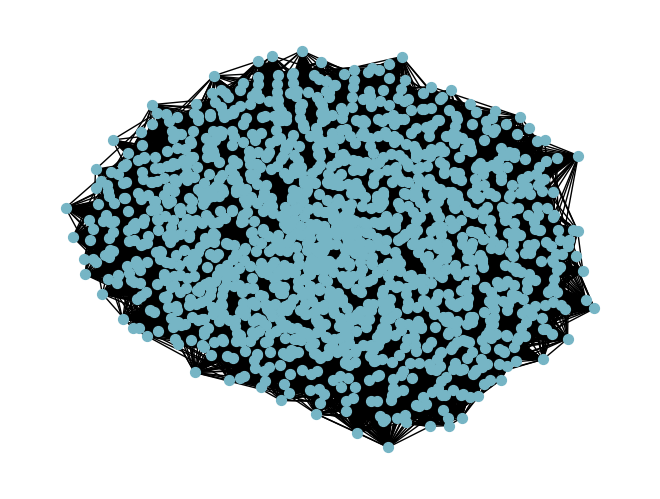

In [ ]:
nx.draw(filtered_G, with_labels=False, node_color='#76b5c5', # Custom color specified as a hex code
        node_size=50, font_size=5 , font_weight='normal', edge_color='black')

# Show the plot
plt.show()

In [ ]:
degrees = dict(filtered_G.degree())  # Converts DegreeView to dictionary

# Calculate the average degree
average_degree = sum(degrees.values()) / len(degrees)
print("Average Degree:", average_degree)
print("Standard Deviation:", np.std(list(degrees.values())))
print('Median Degree:', np.median(list(degrees.values())))
print("Minimum Degree:", min(degrees.values()))
print("Maximum Degree:", max(degrees.values()))


Average Degree: 134.92875318066157
Standard Deviation: 108.69108482919012
Median Degree: 101.0
Minimum Degree: 62
Maximum Degree: 884


In [ ]:
degrees = dict(filtered_G.degree())
sorted_degrees = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
sorted_degrees

[(276, 884),
 (893, 860),
 (620, 854),
 (613, 843),
 (1355, 829),
 (790, 800),
 (129, 797),
 (1566, 778),
 (1014, 763),
 (561, 738),
 (1484, 736),
 (796, 733),
 (853, 724),
 (563, 715),
 (94, 710),
 (452, 704),
 (1098, 695),
 (755, 695),
 (151, 686),
 (1219, 686),
 (1503, 669),
 (419, 669),
 (791, 654),
 (317, 636),
 (1457, 633),
 (538, 626),
 (185, 620),
 (842, 616),
 (1070, 603),
 (920, 584),
 (56, 580),
 (1509, 569),
 (220, 565),
 (1361, 561),
 (128, 551),
 (598, 542),
 (152, 530),
 (168, 526),
 (281, 523),
 (1194, 523),
 (357, 520),
 (1003, 508),
 (167, 507),
 (1254, 506),
 (1114, 501),
 (1161, 474),
 (395, 463),
 (329, 462),
 (1119, 458),
 (1430, 448),
 (164, 441),
 (1205, 437),
 (1325, 433),
 (1030, 433),
 (1310, 429),
 (258, 418),
 (1442, 417),
 (362, 415),
 (1493, 411),
 (904, 410),
 (855, 404),
 (287, 390),
 (1179, 390),
 (1551, 380),
 (303, 379),
 (889, 374),
 (701, 372),
 (1168, 369),
 (810, 369),
 (713, 365),
 (960, 365),
 (1283, 362),
 (519, 361),
 (577, 359),
 (746, 358),

Text(0.5, 1.0, 'Network Graph ')

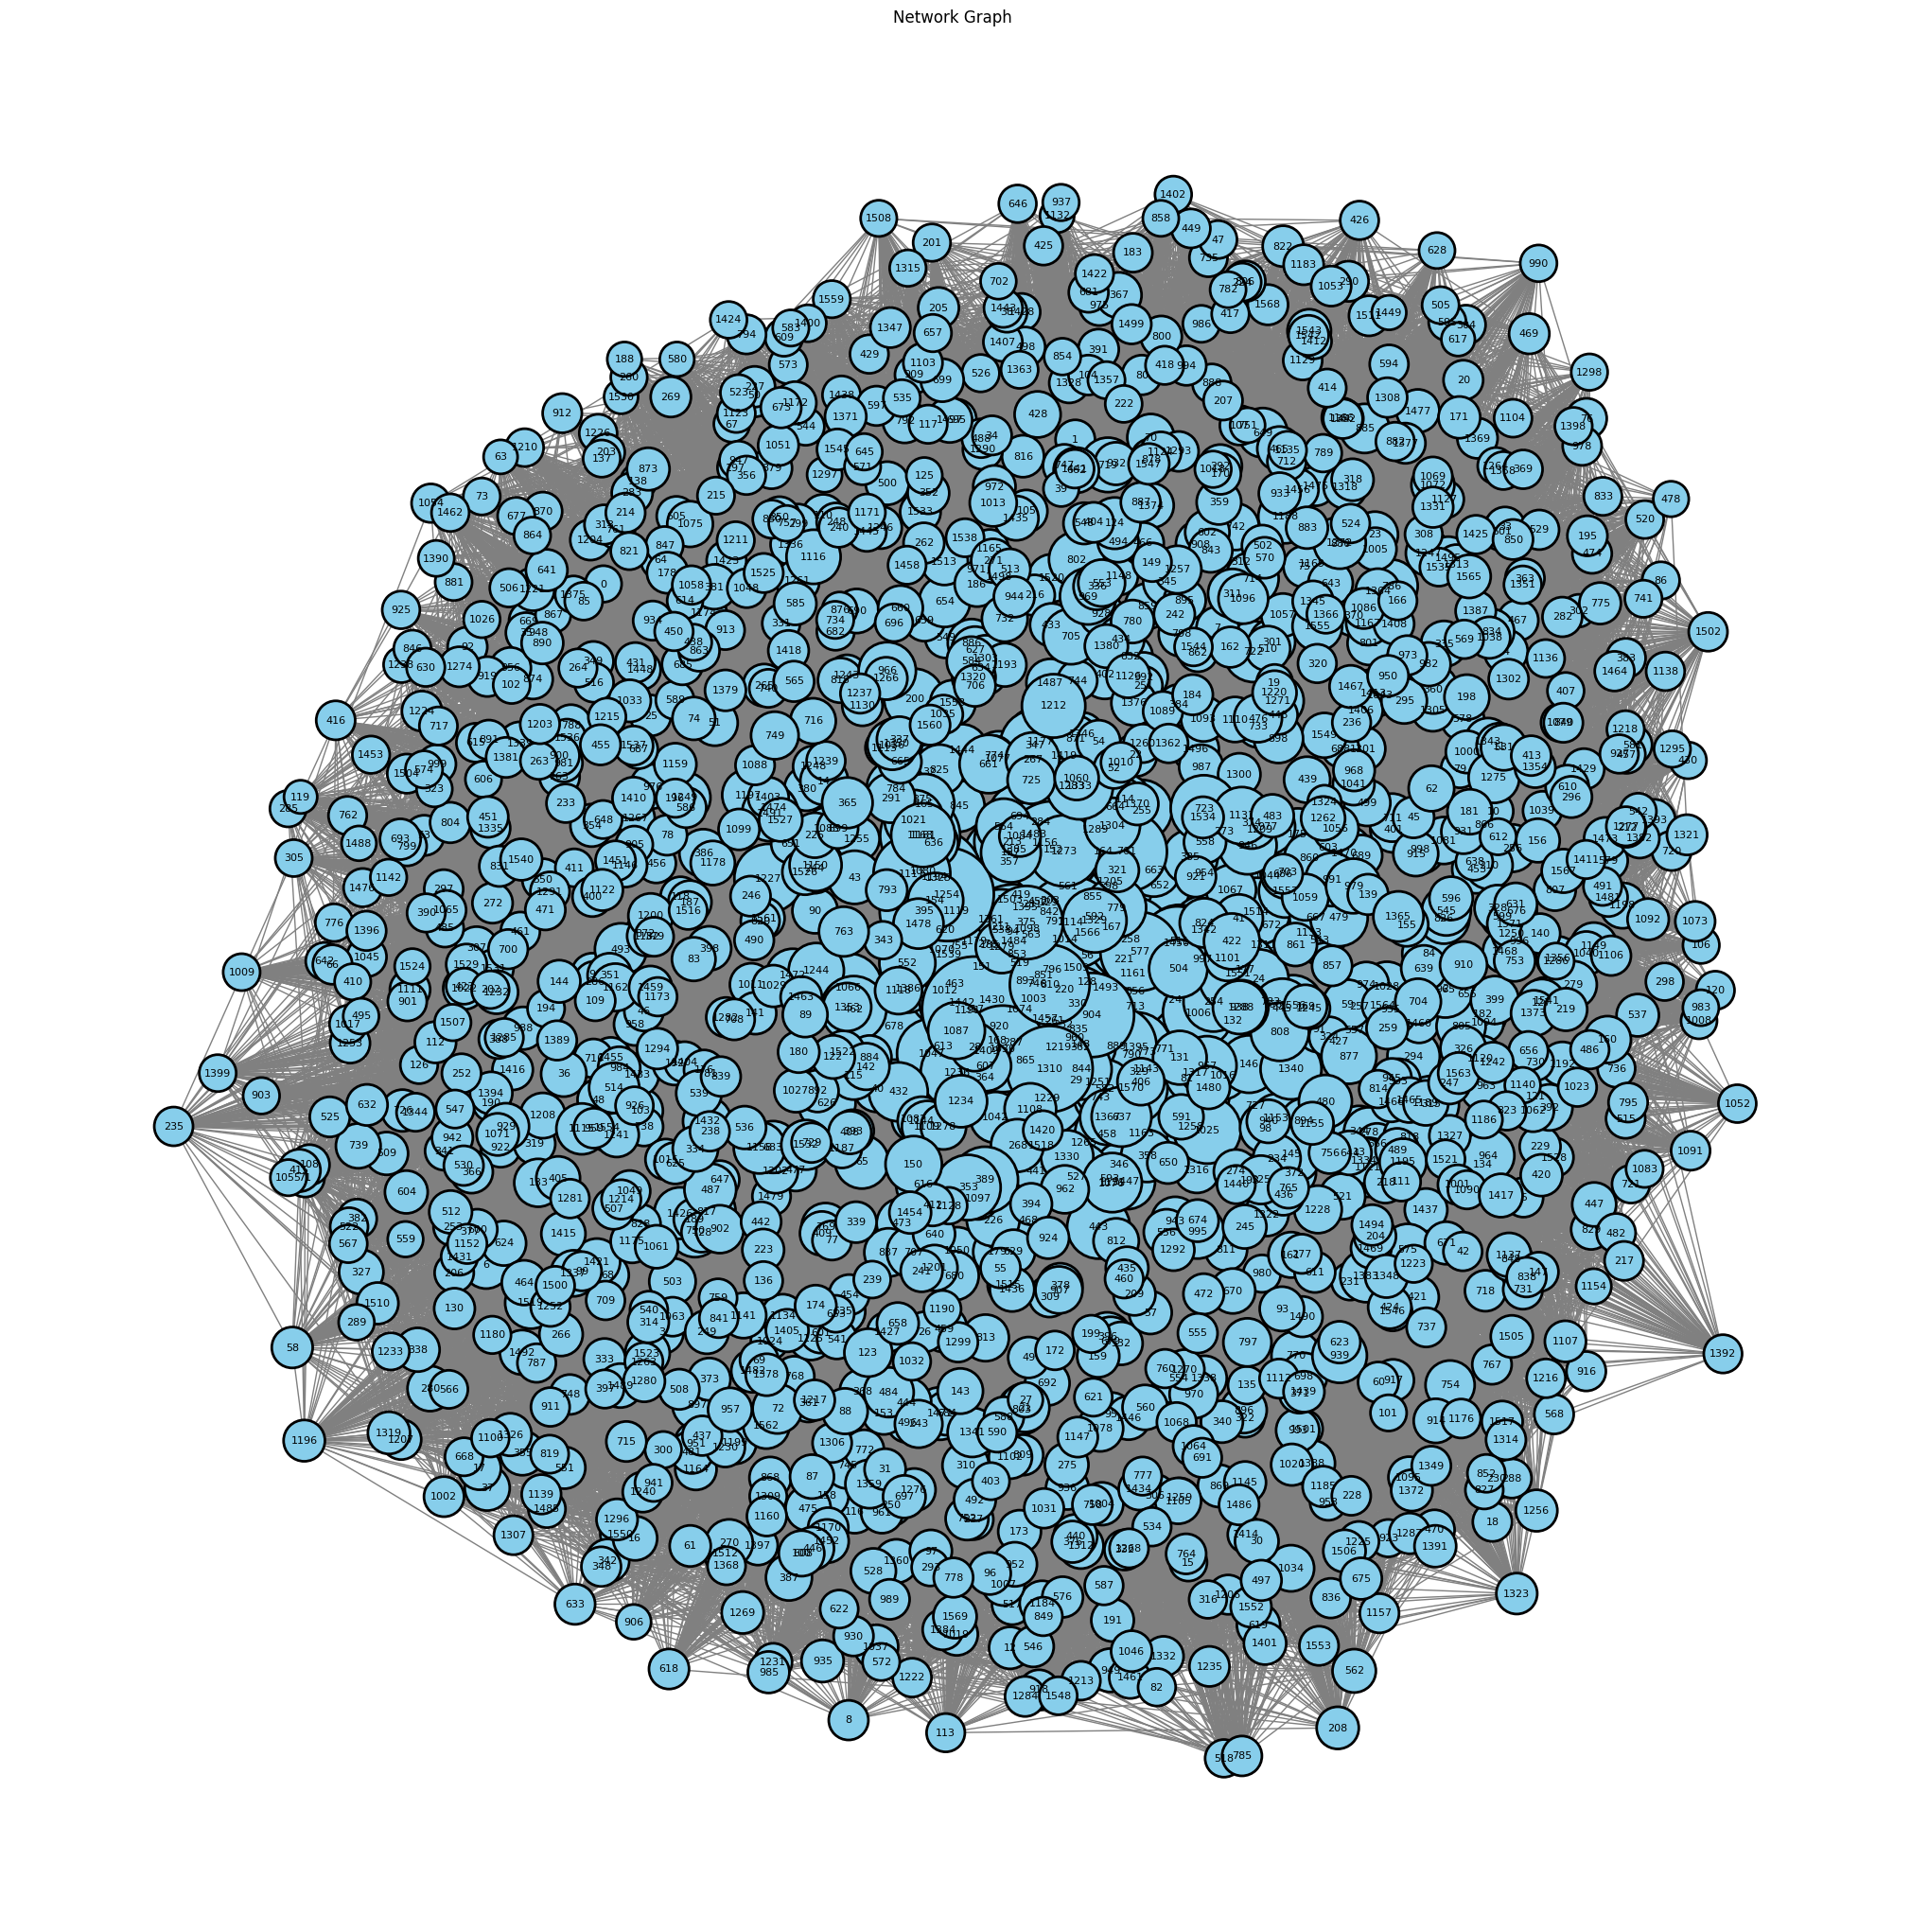

In [ ]:
import matplotlib.pyplot as plt
degrees = [filtered_G.degree(n) * 10 for n in filtered_G.nodes()]  # Scale by 10 for better visualization

# Draw the graph
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(filtered_G, seed=42)  # Seed for reproducibility
nx.draw(filtered_G, pos, node_size=degrees, node_color='skyblue',edge_color='gray',  edgecolors='black', # skyblue fill with black borders
        linewidths=2, with_labels=True,  font_size=8)
plt.title('Network Graph ')

In [ ]:
nx.write_graphml(filtered_G, "synopsis_graph.graphml")

# Now we move on using Adjusted Disparity filtering

In [ ]:
G = nx.read_graphml("synopsis_graph.graphml")
df = pd.read_csv('IMDB_movie_details.csv')

In [ ]:
# Add node attributes from DataFrame including genre, movie_id, title and plot synopsis
for index, row in df.iterrows():
    index = str(index)
    if index in G.nodes():
        G.nodes[index]['title'] = row['title']
        G.nodes[index]['genre'] = row['genre']
        G.nodes[index]['movie_id'] = row['movie_id']
        G.nodes[index]['plot_synopsis'] = row['plot_synopsis']

In [ ]:
G.nodes(data=True)

In [ ]:
nx.write_graphml(G, "synopsis_graph_final.graphml")

# _START FROM HERE_
First run the imports and then move on from here for community detection.

In [ ]:
G = nx.read_graphml("synopsis_graph_final.graphml")
pos = nx.spring_layout(G, seed= 42) #needed for visualization purposes

In [ ]:
G.nodes(data=True)['1']

{'title': 'Last Vegas',
 'genre': "['Comedy']",
 'movie_id': 'tt1204975',
 'plot_synopsis': 'Four boys around the age of 10 are friends in Brooklyn during the \'50s. They have a nickname, the Flatbush Four, and also pal around with a girl. One day they get into a scuffle at a store with a young thug, and steal a bottle of scotch as they run away.58 years later: Sam has retired with his wife to Naples, FL; Archie is living with his son in New Jersey; Paddy lives alone in Brooklyn after his wife Sophie died a year earlier; Billy is wealthy and living in Malibu, CA with a young woman named Lisa.Billy goes to the funeral for his friend Ronnie, and in the process of eulogizing him, while commenting on the shortness of life and love, he spontaneously proposes to Lisa.Billy conference calls Sam and Archie to tell them he is getting married that weekend in Las Vegas, and they not only want to come to the wedding, they want to throw him a bachelor party the night before. All three of them dread

In [ ]:
A_d = nx.adjacency_matrix(G)
print(A_d.todense())

[[0.         0.08320525 0.53297251 ... 0.         0.         0.        ]
 [0.08320525 0.         0.07154529 ... 0.06768553 0.         0.12741685]
 [0.53297251 0.07154529 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.06768553 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.12741685 0.         ... 0.         0.         0.        ]]


## Clusters as communities: Hierarchical clustering

Since every network can be represented as a matrix, such as the Adjacency matrix (or the distance matrix between nodes as you will see later), one way to detect communities in a network is to use classic clustering methods used in machine learning and statistical infernce.

Hierarchical clustering, for instance, is a method that groups similar nodes (i.e. based on a distance measure) together in a hierarchical tree structure called a dendrogram. This hierarchical structure can be cut at a certain level to obtain clusters/communities.

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial import distance

# Create the distance matrix using ... the shortest paths
path_length = dict(nx.all_pairs_shortest_path_length(G))

# Create a list of all nodes to use consistent indexing
nodes = list(G.nodes())
size = len(nodes)

# Initialize the distance matrix with infinity for non-existing paths
distance_matrix = pd.DataFrame(float('inf'), index=nodes, columns=nodes)

# Fill the distance matrix with shortest path lengths
for k, v in path_length.items():
    for j, length in v.items():
        distance_matrix.at[k, j] = length

# Ensure the diagonal is zero (distance from a node to itself)
for node in nodes:
    distance_matrix.at[node, node] = 0

# Convert the distance matrix to a condensed distance matrix
# scipy requires a condensed distance matrix for clustering
condensed_distance_matrix = distance.squareform(distance_matrix.values)

# Perform hierarchical clustering
Z = hierarchy.linkage(condensed_distance_matrix, method='ward')
cutree = hierarchy.cut_tree(Z, n_clusters=[1, 2, 3, 4, 5, 6])
cutree_df = pd.DataFrame(cutree, columns=[f'cluster_{i}' for i in range(1, 7)], index=nodes)


Just for visualization purposes

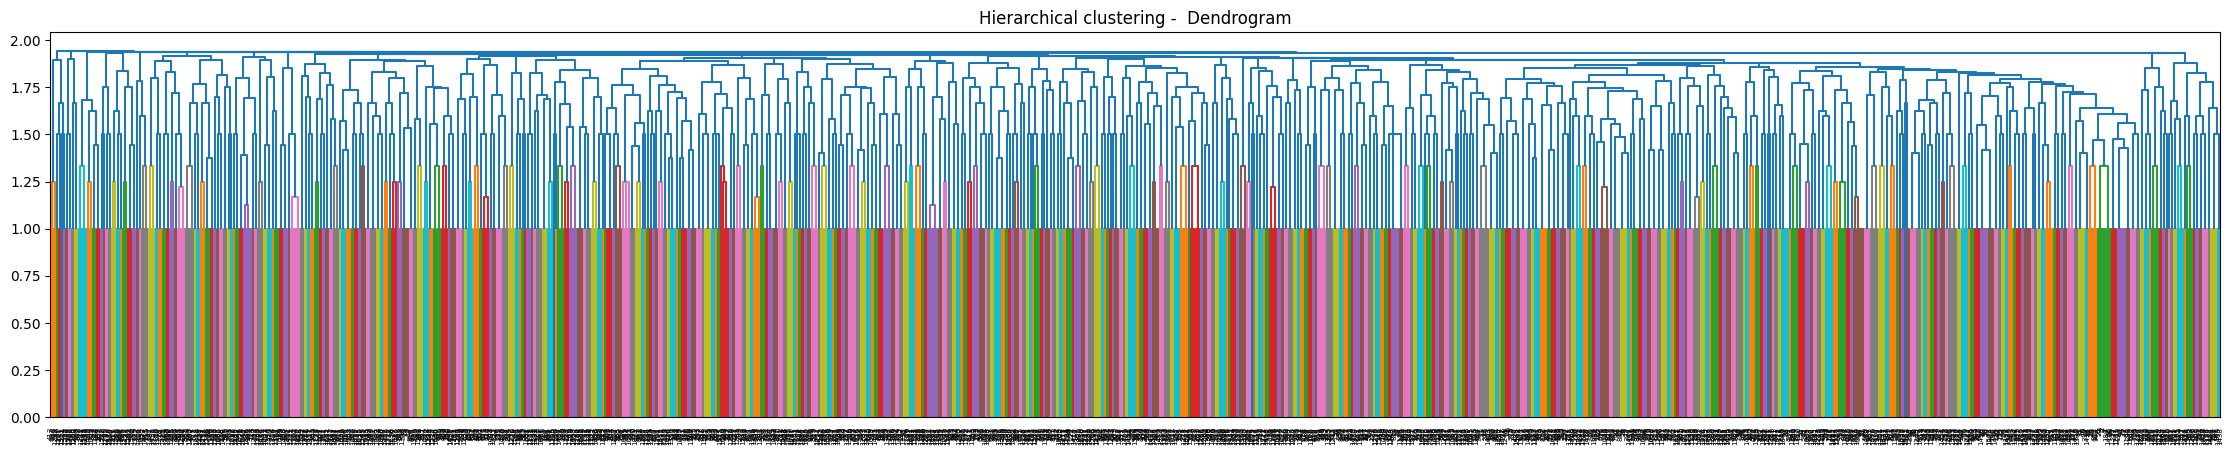

In [ ]:
# put the distance matrix in triangular form and compute the dendrogram
Y = distance.squareform(distance_matrix)
# Compute the dendrogram wiht the average method.
# There are also other methods available simple/complete/max/farthest point linkage
Z = hierarchy.average(Y)

#plot the dendrogram
plt.figure(figsize=(28,5))
hierarchy.dendrogram(Z)
plt.title('Hierarchical clustering -  Dendrogram')
plt.show()

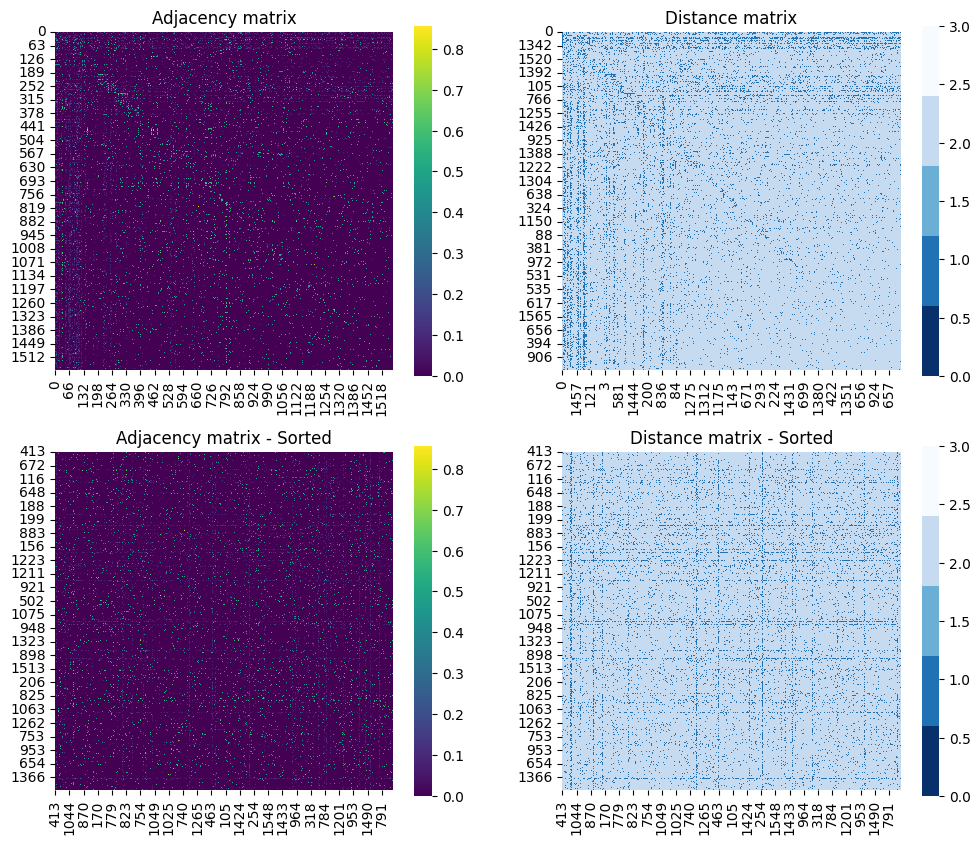

In [ ]:
# plot the adjacency matrix sorting rows and columns using the order made by the clustering
ordered_leaves = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, Y))
ordered_leaves = [str(leaf) for leaf in ordered_leaves] # because our nodes' indexes are strings
fig, axes = plt.subplots(2,2, figsize =(12,10))

# adjacency matrix
axes[0,0].set_title('Adjacency matrix')
sns.heatmap(nx.adjacency_matrix(G).todense(),
            square=True,
            ax= axes[0,0],
            cmap = plt.cm.viridis)
# distance matrix
axes[0,1].set_title('Distance matrix')
sns.heatmap(distance_matrix,
            square=True,
            ax= axes[0,1],
            cmap = plt.get_cmap('Blues_r',5))

# sorted adjacency matrix
axes[1,0].set_title('Adjacency matrix - Sorted')
sns.heatmap(pd.DataFrame(nx.adjacency_matrix(G).todense(), index=G.nodes(), columns=G.nodes()).loc[ordered_leaves,ordered_leaves],
            square=True,
            ax= axes[1,0],
            cmap = plt.cm.viridis)
#sorted distance matrix
axes[1,1].set_title('Distance matrix - Sorted')
sns.heatmap(pd.DataFrame(distance_matrix).loc[ordered_leaves,ordered_leaves],
            square=True,
            ax= axes[1,1],
            cmap = plt.get_cmap('Blues_r',5))

plt.show()

## The Girvan-Newman Algorithm

Introduced by Girvan and Newman in 2002, in their famous paper of the community structure in social and bìiological networks \
[Girvan & Newman, (2002). Community structure in social and biological networks.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC122977/)

This is a divisive methods, which recursively remove edges from the network to break it into smaller components. The algorithm works by computing the betweenness centrality of all edges in the network and removing the edge with the highest betweenness centrality at each step. This process is repeated until the desired number of communities is obtained or when alla nodes are separated in as many partitions.

### We could not use GN since calculating betweenness centrality for each node for each iteration was computationally unfeasible

## Modularity

Modularity measures the strength of the division of a network into partitions.

We can see it as the fraction of the edges that lie within the same group
minus the expected fraction if edges were distributed at random.

$ Q = \frac{1}{2m} \sum_{ij} \left( A_{ij} - \frac{k_ik_j}{2m}\right)\delta(c_i,c_j)$

where $m$ is the number of edges, $A$ is the adjacency matrix of `G`,
$k_i$ is the degree of $i$, $\gamma$ is the resolution parameter,
and $\delta(c_i, c_j)$ is 1 if $i$ and $j$ are in the same community else 0.

or

$Q = \sum_{c=1}^{n} Q_c = \sum_{c=1}^{n}\left[ \frac{L_c}{m} - \left( \frac{k_c}{2m} \right) ^2 \right]$

where the sum iterates over all communities $c$, $m$ is the number of edges,
$L_c$ is the number of intra-community links for community $c$,
$k_c$ is the sum of degrees of the nodes in community $c$,
and $\gamma$ is the resolution parameter

## Louvain Algorithm

The Louvain algorithm is a greedy and agglomerative algorithm for community detection.

This algorithm greedily maximizes modularity.

Each pass is made of two phases:

Phase 1. -  Modularity is optimised by allowing only local changes to node-community membership

Phase 2. - The identified communities are aggregated into “super nodes” to build a new network


The passes are repeated iteratively until no increase in modularity is possible.

In [ ]:
import community
from community import community_louvain

# find partition with Louvain algorithm
louvain_partition = community_louvain.best_partition(G,weight = 'weight', random_state = 42)

In [ ]:
print('Modularity:', community_louvain.modularity(louvain_partition, G, weight = 'weight'))

Modularity: 0.2792661326483085


In [ ]:
Q = community_louvain.modularity(louvain_partition,G,weight = 'weight')
dendro = community_louvain.generate_dendrogram(G, weight = 'weigth', random_state = 42)


In [ ]:
set(louvain_partition.values())

{0, 1, 2, 3, 4, 5}

(-1.1333470940589905,
 0.9759939312934875,
 -1.202139201760292,
 1.1272744566202164)

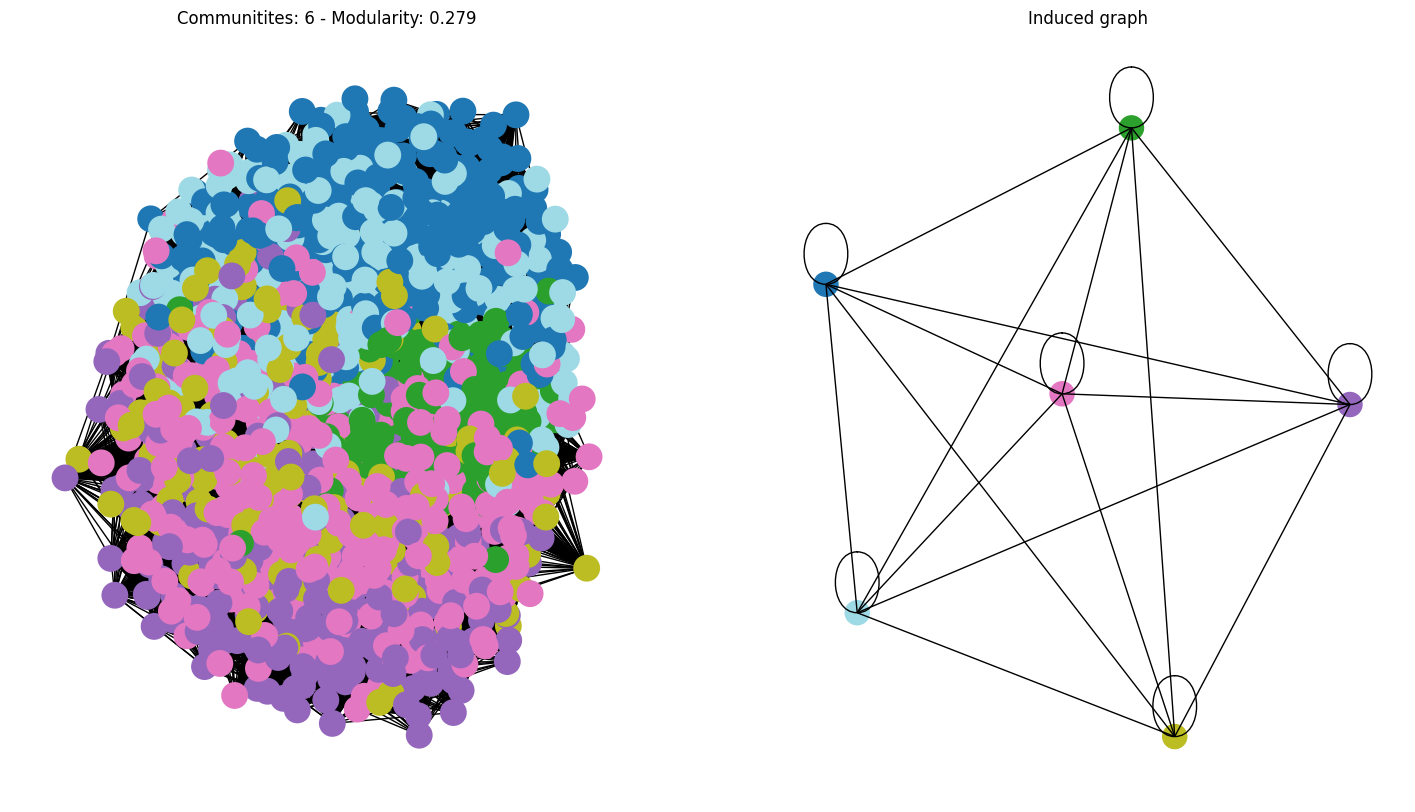

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (18,10))

# graph with communities
nx.draw_networkx_nodes(G,
                        pos,
                        node_color= list(louvain_partition.values()),
                        linewidths= 2,
                        cmap=plt.cm.tab20,
                        ax = axes[0])
nx.draw_networkx_edges(G,
                        pos,
                        ax = axes[0])

axes[0].set_title(f"Communitites: {len(set(louvain_partition.values()))} - Modularity: {round(Q, 3)}")

# induced graph
ind = community_louvain.induced_graph(louvain_partition, G)

pos_ind = nx.spring_layout(ind, seed = 20)
no = nx.draw_networkx_nodes(ind,
                node_color = pd.Series(louvain_partition).drop_duplicates().values,
                cmap=plt.cm.tab20,
                pos= pos_ind, ax =axes[1])
ed = nx.draw_networkx_edges(ind,
                pos = pos_ind,
                ax = axes[1])

# Get edge weights
edge_weights = nx.get_edge_attributes(G, 'weight')
# Round the edge weights to avoid links to be hidden by labels
rounded_edge_weights = {edge: round(weight, 1) for edge, weight in edge_weights.items()}

no.set_zorder(1)
axes[1].set_title(f"Induced graph")

axes[1].axis('off')
axes[0].axis('off')


## Infomap

In [ ]:
%%capture
!pip install infomap

In [ ]:
nx.get_edge_attributes(G, 'weight')

{('0', '56'): 0.08320525288581848,
 ('0', '90'): 0.532972514629364,
 ('0', '94'): 0.06115487590432167,
 ('0', '151'): 0.017340485006570816,
 ('0', '164'): 0.08517802506685257,
 ('0', '167'): 0.07273344695568085,
 ('0', '168'): 0.12094192206859589,
 ('0', '177'): 0.03565528988838196,
 ('0', '185'): 0.0897325724363327,
 ('0', '197'): 0.5301889777183533,
 ('0', '220'): 0.09907251596450806,
 ('0', '221'): 0.12418654561042786,
 ('0', '255'): 0.12262855470180511,
 ('0', '287'): 0.12519194185733795,
 ('0', '303'): 0.06172216311097145,
 ('0', '307'): 0.5680750608444214,
 ('0', '357'): 0.10784395039081573,
 ('0', '380'): 0.5768678188323975,
 ('0', '421'): 0.5518177151679993,
 ('0', '452'): 0.03459583967924118,
 ('0', '477'): 0.5257635116577148,
 ('0', '500'): 0.5203137397766113,
 ('0', '538'): 0.10630404949188232,
 ('0', '543'): 0.09169711917638779,
 ('0', '549'): 0.5209711790084839,
 ('0', '561'): 0.11659841984510422,
 ('0', '563'): 0.07802405953407288,
 ('0', '592'): 0.09979790449142456,
 ('0

Community membership of each node:
Node 0: Community 0
Node 56: Community 0
Node 90: Community 0
Node 94: Community 0
Node 151: Community 0
Node 164: Community 0
Node 167: Community 0
Node 168: Community 0
Node 177: Community 0
Node 185: Community 0
Node 197: Community 0
Node 220: Community 0
Node 221: Community 0
Node 255: Community 0
Node 287: Community 0
Node 303: Community 0
Node 307: Community 0
Node 357: Community 0
Node 380: Community 0
Node 421: Community 0
Node 452: Community 0
Node 477: Community 0
Node 500: Community 0
Node 538: Community 0
Node 543: Community 0
Node 549: Community 0
Node 561: Community 0
Node 563: Community 0
Node 592: Community 0
Node 598: Community 0
Node 613: Community 0
Node 620: Community 0
Node 652: Community 0
Node 672: Community 0
Node 678: Community 0
Node 694: Community 0
Node 727: Community 0
Node 790: Community 0
Node 796: Community 0
Node 816: Community 0
Node 842: Community 0
Node 853: Community 0
Node 855: Community 0
Node 874: Community 0
No

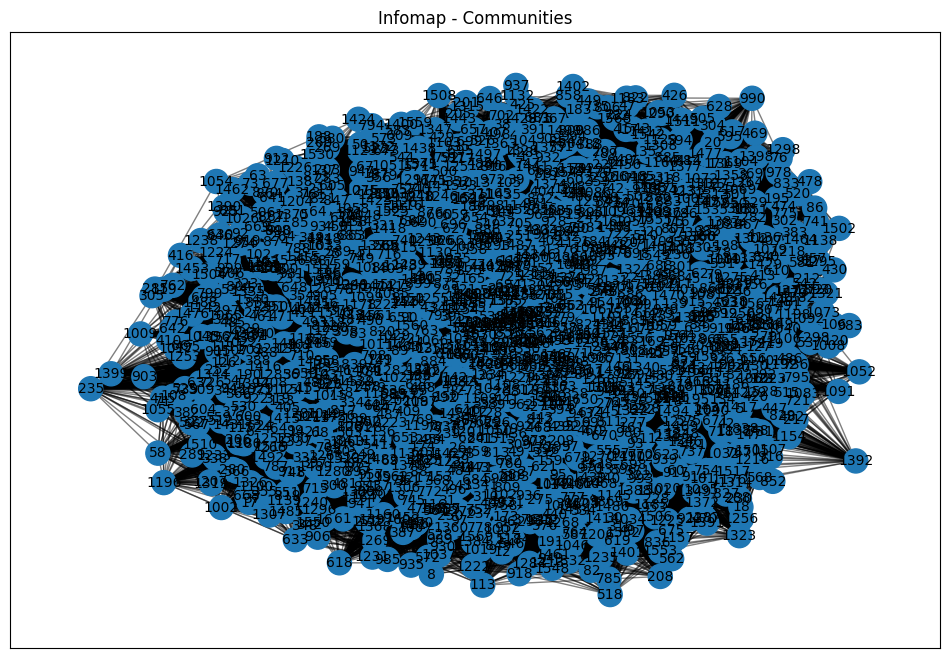

In [ ]:
from infomap import Infomap

def apply_infomap(nx_graph):
    # Create a mapping from string node identifiers to integers
    node_to_int = {node: idx for idx, node in enumerate(nx_graph.nodes())}
    int_to_node = {idx: node for node, idx in node_to_int.items()}

    # Initialize Infomap
    infomap = Infomap()

    # Add edges to Infomap using integer identifiers
    for edge in nx_graph.edges(data=True):
        source, target = edge[:2]
        weight = edge[2].get('weight', 1.0)  # Default weight is 1.0 if not provided
        infomap.add_link(node_to_int[source], node_to_int[target], float(weight))

    # Run Infomap algorithm
    infomap.run()

    # Extract the best partition
    communities = {}
    for node in infomap.iterTree():
        if node.isLeaf():
            communities[int_to_node[node.physicalId]] = node.moduleIndex()

    return communities



# Apply Infomap
communities = apply_infomap(G)

# Add the community as a node attribute in the graph
for node, community in communities.items():
    G.nodes[node]['community'] = community

# Print the resulting community membership of each node
print("Community membership of each node:")
for node in G.nodes(data=True):
    print(f"Node {node[0]}: Community {node[1]['community']}")


plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color=[G.nodes[node]['community'] for node in G.nodes], cmap=plt.cm.tab20, node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
plt.title("Infomap - Communities")
plt.show()


In [ ]:
#how many communities are there?
len(set(communities.values()))

1

As expected infomap is shrinking to just one community

# Final comparison

In [ ]:
nx.set_node_attributes(G, louvain_partition, 'community')

In [ ]:
# Perform hierarchical clustering
Z = hierarchy.linkage(nx.to_numpy_array(G), method='ward')

# Cut the hierarchical clustering tree
cutree = hierarchy.cut_tree(Z)

# Get actual node labels (which are strings in this case)
node_labels = list(G.nodes())

# Dictionary to store modularity for different cuts
mod_hierarchical = dict()

# Calculate modularity for each cut
for i in range(cutree.shape[1]):
    part_cut = {node_labels[j]: community for j, community in enumerate(cutree[:, i])}
    mod_hierarchical[len(G) - i] = community_louvain.modularity(part_cut, G, weight='weight')

mod_hierarchical = pd.Series(mod_hierarchical)

# Find the best cut
best_cut_index = mod_hierarchical.idxmax()
hierarchical_partition = cutree[:, cutree.shape[1] - best_cut_index]

# Evaluate Modularity for both algorithms
modularity_louvain = community_louvain.modularity(louvain_partition, G, weight='weight')
modularity_hierarchical = mod_hierarchical.max()

print(f"Modularity (Louvain): {modularity_louvain}")
print(f"Modularity (Best Hierarchical): {modularity_hierarchical}")

<ipython-input-91-a8d3ad8cdfa4>:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(nx.to_numpy_array(G), method='ward')


Modularity (Louvain): 0.2792661326483085
Modularity (Best Hierarchical): 0.16885967486795106


In [ ]:
partition_data = {
    'Louvain': [louvain_partition[str(node)] for node in G.nodes()],
    'Hierarchical': hierarchical_partition
}

# Create the DataFrame
all_partitions = pd.DataFrame(partition_data, index=[str(node) for node in G.nodes()])

# Display the DataFrame
all_partitions.head()

Louvain  Hierarchical
0          0             0
56         1             1
90         3             2
94         3             3
151        1             1

In [ ]:
L = all_partitions.Hierarchical.values
set(L)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [ ]:
#show the title of the movies in each community
for community in set(louvain_partition.values()):
    print(f'Community {community}:')
    for node, data in G.nodes(data=True):
        if data['community'] == community:
            print(f"  - {node, data['title']}")
    print()

Community 0:
  - ('0', 'Giochi di potere')
  - ('197', 'American History X')
  - ('538', 'Dragon - La storia di Bruce Lee')
  - ('598', 'La vita è un sogno')
  - ('816', 'Prisoners')
  - ('874', 'Tra le nuvole')
  - ('1014', 'East Is East')
  - ('1077', 'Assassini nati - Natural Born Killers')
  - ('1243', 'Four Brothers - Quattro fratelli')
  - ('1246', 'Fratellastri a 40 anni')
  - ('1247', 'Mia moglie per finta')
  - ('1297', 'Shining')
  - ('1325', 'The Originals')
  - ('1', 'Last Vegas')
  - ('201', "Lost in Translation - L'amore tradotto")
  - ('281', 'Beyond Skyline')
  - ('284', 'Sleepers')
  - ('290', 'Un amore di testimone')
  - ('292', 'Un weekend da bamboccioni')
  - ('402', 'Gli stagisti')
  - ('659', 'Warrior')
  - ('714', 'Bad Moms: Mamme molto cattive')
  - ('722', 'Un disastro di ragazza')
  - ('742', 'Giovani, pazzi e svitati')
  - ('791', "L'ultimo boy scout - Missione: sopravvivere")
  - ('822', 'Finalmente maggiorenni')
  - ('886', 'Come ti rovino le vacanze')
  - 